In [ ]:
%pip install transformers

In [11]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#code to test current initial model from the dialoGPT documentation https://huggingface.co/microsoft/DialoGPT-medium?text=Hey+my+name+is+Julien%21+How+are+you%3F
#for this to run requires instantuating tokenizer and model as done below, so this code block will not work unless you add that
chat_history_ids = None
for step in range(5):


    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids
    bot_input_ids = bot_input_ids.to(device)

    # generated a response while limiting the total chat history to 1000 tokens,
    chat_history_ids = model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id).to("cpu")

    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:hello I need help with something


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: I'm here to guide you through the process of making a purchase with us. To make the purchase process seamless, could you please provide me with the details of the purchase you would like to make? This information will help me guide you through the process and ensure that you have a smooth experience.
>> User:can I book a flight with you


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: 
1. Log in to your account on our website.
2. Navigate to the "Billing" or "Profile" section.
3. Look for the option to view your purchase history.
4. Look for the purchase associated with the purchase number "Billing" or "Billing"
5. Click on the purchase.
6. You will be prompted to provide the necessary details of the purchase.
7. Follow the instructions provided in the purchase and select the "Forgot option.

If you encounter any difficulties or have further questions, please don't hesitate to reach out to our customer support team. They are available {{Customer Support Phone Number}} at {{Customer Support Phone Number}} at {{Website URL}}. We are here to assist you every step of the way!"
>> User:what time is my flight?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: 
>> User:when is it scheduled to leave?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: If you have any specific order or if you have any specific questions or if there's not received the same questions, please don't hesitate to let me know. I'll be happy to help you with the process.
>> User:im not ordering anything stupid


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: 


In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/Customer-Support-Augmented.csv'
test_path = '/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/test.csv'

data = pd.read_csv(file_path, encoding="latin-1",error_bad_lines=False)
testdata = pd.read_csv(test_path, encoding="latin-1",error_bad_lines=False)
#show data example
data

<ipython-input-15-4fa5b2eb709e>:12: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(file_path, encoding="latin-1",error_bad_lines=False)
<ipython-input-15-4fa5b2eb709e>:13: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  testdata = pd.read_csv(test_path, encoding="latin-1",error_bad_lines=False)


,query,response
0,My order hasn't arrived yet.,We apologize for the inconvenience. Can you pl...
1,I received a damaged product.,We apologize for the inconvenience. Can you pl...
2,I need to return an item.,Certainly. Please provide your order number an...
3,I want to change my shipping address.,No problem. Can you please provide your order ...
4,I have a question about my bill.,We'd be happy to help. Can you please provide ...
...,...,...
150,Infant traveling policy?,"We ensure a comfortable journey for all, inclu..."
151,Group discount?,Group travel can be quite rewarding. Please pr...
152,"Flight number ABC123, seat selection?",Thank you for providing your flight number. Fo...
153,"XYZ456, meal options?","For flight XYZ456, we offer a variety of meal ..."


In [49]:
#this code block does the preliminary score calculations for the original DialoGPT model using the test set derived from the long_customer_support.csv dataset

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#this is the portion of instantiating I was referring to above
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
tokenizer.pad_token = '[PAD]'
#this is the portion of instantiating I was referring to above
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small").to(device)
file_path = '/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/long_customer_support.csv'
full_data = pd.read_csv(file_path)
full_data = full_data[['instruction', 'response']]
test_percentage = 0.01
num_samples = int(len(full_data) * test_percentage)
test_data = full_data.sample(n=num_samples, random_state=42)
test_response = []
test_query = []
test_data = pd.DataFrame(test_data)

#extract the queries and responses
for index, row in test_data.iterrows():
    value1 = row['instruction']
    value2 = row['response']
    test_query.append(value1)
    test_response.append(value2)


generated_responses = []
print(test_query, test_response)

#add model responses to generated responses list
for i in range(len(test_query)):
  bot_input_ids = tokenizer.encode(test_query[i] + tokenizer.eos_token, return_tensors='pt').to(device)
  chat_history_ids = model.generate(bot_input_ids, max_length=200, pad_token_id=tokenizer.eos_token_id).to("cpu")
  generated_responses.append(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True))


#calculate bleu/meteor/avg len scores
bleu_scores = [sentence_bleu([actual_response], generated_response) for actual_response, generated_response in zip(test_response, generated_responses)]
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU Score:", average_bleu_score)

tokenized_generated_responses = [response.split() for response in generated_responses]
tokenized_train_responses = [response.split() for response in test_response]

meteor_scores = [meteor_score([ref], gen) for ref, gen in zip(tokenized_train_responses, tokenized_generated_responses)]
average_meteor_score = sum(meteor_scores) / len(meteor_scores)
print("Average METEOR Score:", average_meteor_score)

total_length = sum(len(response.split()) for response in generated_responses)
print("Total Length of Generated Responses:", total_length)


print(len(generated_responses))


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


["I can't talk with  a human agent", 'I have got to locate hte bills from {{Person Name}}', 'I cannot pay, help me to inform of a problem with payments', 'I want help speaking to customer service', 'I try to see th accepted payment options', 'where to sign up to the company nmewsletter', "I'd like to see the withdrwaal fee how can i do it", 'I want to speak with someone', 'can you help me getting bill #85632?', "I don't know how to take a quick look at invoice #12588", "I don't know how to delete my platinum account", 'help me check in what cases can I ask to be refunded', 'is it possible to locate my bill from {{Person Name}}', 'i want help to file a consumer claim against ur organization', 'uhave a free number to call customer support', 'i do not know how i can see the early termination penalties', 'could you help me to unsubscribe to the damn newsletter?', "I don't know how to inform of problems with a signup", 'download bill from {{Person Name}}', 'want assistance receiving a refun

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

Average BLEU Score: 0.0006954771849944626
Average METEOR Score: 0.021365100069597003
Total Length of Generated Responses: 2232
268


In [48]:
#this code block does the preliminary score calculations for the original DialoGPT model using the test set derived from the test.csv dataset that we created for empathy

test_data = pd.read_csv('/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/test.csv')

test_query = []
test_response = []
for index, row in test_data.iterrows():
    value1 = row['query']
    value2 = row['response']
    test_query.append(value1)
    test_response.append(value2)
generated_responses = []
for i in range(len(test_query)):
  bot_input_ids = tokenizer.encode(test_query[i] + tokenizer.eos_token, return_tensors='pt').to(device)
  chat_history_ids = model.generate(bot_input_ids, max_length=200, pad_token_id=tokenizer.eos_token_id).to("cpu")
  generated_responses.append(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True))


#find scores
bleu_scores = [sentence_bleu([actual_response], generated_response) for actual_response, generated_response in zip(test_response, generated_responses)]
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU Score:", average_bleu_score)
tokenized_generated_responses = [response.split() for response in generated_responses]
tokenized_train_responses = [response.split() for response in test_response]
meteor_scores = [meteor_score([ref], gen) for ref, gen in zip(tokenized_train_responses, tokenized_generated_responses)]
average_meteor_score = sum(meteor_scores) / len(meteor_scores)
print("Average METEOR Score:", average_meteor_score)
total_length = sum(len(response.split()) for response in generated_responses)
print("Total Length of Generated Responses:", total_length)


print(len(generated_responses))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

Average BLEU Score: 0.05857146514721562
Average METEOR Score: 0.06504231454801185
Total Length of Generated Responses: 403
41


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [2]:
#this code block does the score calculations for the finetuned DialoGPT model trained on the long_customer_support dataset using the test set derived from the long_customer_support.csv dataset
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from tqdm import tqdm
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
tokenizer.pad_token = '[PAD]'
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small").to(device)
file_path = '/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/long_customer_support.csv'
full_data = pd.read_csv(file_path)
print(full_data)
full_data = full_data[['instruction', 'response']]
fine_tune_percentage = 0.05
num_samples = int(len(full_data) * fine_tune_percentage)
fine_tune_data = full_data.sample(n=num_samples, random_state=42)
train_size = int(0.8 * len(fine_tune_data))
train_data, test_data = fine_tune_data.iloc[:train_size], fine_tune_data.iloc[train_size:]
train_response = []
train_query = []
train_data = pd.DataFrame(train_data)
for index, row in train_data.iterrows():
    value1 = row['instruction']
    value2 = row['response']

    train_query.append(value1)
    train_response.append(value2)

test_response = []
test_query = []
test_data = pd.DataFrame(test_data)
for index, row in test_data.iterrows():
    value1 = row['instruction']
    value2 = row['response']

    test_query.append(value1)
    test_response.append(value2)

tokenized_train_data = tokenizer(train_query, train_response, padding=True, truncation=True, return_tensors='pt')
class CustomDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)
#define dataloader for batching
train_dataset = CustomDataset(tokenized_train_data)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
optimizer = AdamW(model.parameters(), lr=5e-5)

#train with 3 epochs
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} finished, Average Loss: {average_loss}")


save_directory = '/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/finetuned_bigdataset'
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

       flags                                        instruction category  \
0          B   question about cancelling order {{Order Number}}    ORDER   
1        BQZ  i have a question about cancelling oorder {{Or...    ORDER   
2       BLQZ    i need help cancelling puchase {{Order Number}}    ORDER   
3         BL         I need to cancel purchase {{Order Number}}    ORDER   
4      BCELN  I cannot afford this order, cancel purchase {{...    ORDER   
...      ...                                                ...      ...   
26867     BL  I am waiting for a rebate of {{Refund Amount}}...   REFUND   
26868    BIL  how to see if there is anything wrong with my ...   REFUND   
26869   BLQZ  I'm waiting for a reimbjrsement of {{Currency ...   REFUND   
26870     BL  I don't know what to do to see my reimbursemen...   REFUND   
26871     BL  I need to know if there is anything new on the...   REFUND   

             intent                                           response  
0      cancel_

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0 finished, Average Loss: 1.1636162671777937
Epoch 1 finished, Average Loss: 0.6590184412620685
Epoch 2 finished, Average Loss: 0.5350966420438554


NameError: ignored

In [3]:
#this code block calculates the bleu score for this example
generated_responses = []

for i in range(len(test_query)):
  bot_input_ids = tokenizer.encode(test_query[i] + tokenizer.eos_token, return_tensors='pt').to(device)
  chat_history_ids = model.generate(bot_input_ids, max_length=200, pad_token_id=tokenizer.eos_token_id).to("cpu")
  generated_responses.append(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True))

bleu_scores = [sentence_bleu([actual_response], generated_response) for actual_response, generated_response in zip(test_response, generated_responses)]
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU Score:", average_bleu_score)

tokenized_generated_responses = [response.split() for response in generated_responses]
tokenized_train_responses = [response.split() for response in test_response]




A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

Average BLEU Score: 0.27864110662339736


NameError: ignored

In [6]:
#this code block calculates the meteor and total length of generated responses for the above case
from nltk.translate.meteor_score import meteor_score

meteor_scores = [meteor_score([ref], gen) for ref, gen in zip(tokenized_train_responses, tokenized_generated_responses)]
average_meteor_score = sum(meteor_scores) / len(meteor_scores)
print("Average METEOR Score:", average_meteor_score)
total_length = sum(len(response.split()) for response in generated_responses)
print("Total Length of Generated Responses:", total_length)

Average METEOR Score: 0.1907523504229613
Total Length of Generated Responses: 19821


In [44]:
#this code block does the score calculations for the finetuned DialoGPT model trained on the long_customer_support dataset using the test set from test.csv for human empathy
test_data = pd.read_csv('/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/test.csv')
test_query = []
test_response = []
for index, row in test_data.iterrows():
    value1 = row['query']
    value2 = row['response']

    test_query.append(value1)
    test_response.append(value2)

fine_tuned_model_path = '/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/finetuned_bigdataset'
fine_tuned_model = AutoModelForCausalLM.from_pretrained(fine_tuned_model_path).to(device)
model = fine_tuned_model
generated_responses = []


for i in range(len(test_query)):
  bot_input_ids = tokenizer.encode(test_query[i] + tokenizer.eos_token, return_tensors='pt').to(device)
  chat_history_ids = model.generate(bot_input_ids, max_length=200, pad_token_id=tokenizer.eos_token_id).to("cpu")
  generated_responses.append(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True))


#find the scores
bleu_scores = [sentence_bleu([actual_response], generated_response) for actual_response, generated_response in zip(test_response, generated_responses)]
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU Score:", average_bleu_score)
tokenized_generated_responses = [response.split() for response in generated_responses]
tokenized_train_responses = [response.split() for response in test_response]
meteor_scores = [meteor_score([ref], gen) for ref, gen in zip(tokenized_train_responses, tokenized_generated_responses)]
average_meteor_score = sum(meteor_scores) / len(meteor_scores)
print("Average METEOR Score:", average_meteor_score)
total_length = sum(len(response.split()) for response in generated_responses)
print("Total Length of Generated Responses:", total_length)

print(len(generated_responses))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

Average BLEU Score: 0.15990296607472698
Average METEOR Score: 0.16007071694549094
Total Length of Generated Responses: 3918
41


In [17]:
losses = [] #lr 5e-5 epoch 30
losses1 = [] #lr 5e-2 epoch 30
losses2 = [] #lr 5e-7 epoch 30
losses4 = []#lr 10e-5 epoch 30
losses5 = []#lr 2.5e-5 epoch 30



In [43]:
vallosses = [] #lr 5e-5 epoch 30 // 5
vallosses2 = [] #lr 5e-7 epoch 30 // 10
vallosses4 = []#lr 10e-5 epoch 30 // 20
vallosses5 = []#lr 2.5e-5 epoch 30 // 30



In [47]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
tokenizer.pad_token = '[PAD]'

model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small").to(device)

file_path = '/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/Customer-Support-Augmented.csv'
full_data = pd.read_csv(file_path)

full_data = full_data[['query', 'response']]

train_size = int(len(full_data) * 0.8)
train_data = full_data.iloc[:train_size]
valid_data = full_data.iloc[train_size:]

train_response = []
train_query = []

for index, row in train_data.iterrows():
    value1 = row['query']
    value2 = row['response']

    train_query.append(value1)
    train_response.append(value2)

valid_response = []
valid_query = []

for index, row in valid_data.iterrows():
    value1 = row['query']
    value2 = row['response']

    valid_query.append(value1)
    valid_response.append(value2)

tokenized_train_data = tokenizer(train_query, train_response, padding=True, truncation=True, return_tensors='pt')
tokenized_valid_data = tokenizer(valid_query, valid_response, padding=True, truncation=True, return_tensors='pt')

class CustomDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

#creating dataloaders
train_dataset = CustomDataset(tokenized_train_data)
valid_dataset = CustomDataset(tokenized_valid_data)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 30
train_losses = []


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch} (Training)"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} (Training) finished, Average Loss: {average_loss}")
    train_losses.append(average_loss)

    #get the validation loss
    model.eval()
    total_valid_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f"Epoch {epoch} (Validation)"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)

            loss = outputs.loss
            total_valid_loss += loss.item()

    average_valid_loss = total_valid_loss / len(valid_loader)
    print(f"Epoch {epoch} (Validation) finished, Average Loss: {average_valid_loss}")
    vallosses5.append(average_valid_loss)


# plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
# plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Curves')
# plt.legend()
# plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 0 (Training): 100%|██████████| 16/16 [00:01<00:00, 12.40it/s]


Epoch 0 (Training) finished, Average Loss: 4.016958996653557


Epoch 0 (Validation): 100%|██████████| 4/4 [00:00<00:00, 27.68it/s]


Epoch 0 (Validation) finished, Average Loss: 3.80044025182724


Epoch 1 (Training): 100%|██████████| 16/16 [00:01<00:00, 12.15it/s]


Epoch 1 (Training) finished, Average Loss: 2.415347456932068


Epoch 1 (Validation): 100%|██████████| 4/4 [00:00<00:00, 50.32it/s]


Epoch 1 (Validation) finished, Average Loss: 3.2652177214622498


Epoch 2 (Training): 100%|██████████| 16/16 [00:00<00:00, 16.11it/s]


Epoch 2 (Training) finished, Average Loss: 1.939401313662529


Epoch 2 (Validation): 100%|██████████| 4/4 [00:00<00:00, 29.03it/s]


Epoch 2 (Validation) finished, Average Loss: 3.0870349407196045


Epoch 3 (Training): 100%|██████████| 16/16 [00:01<00:00, 12.91it/s]


Epoch 3 (Training) finished, Average Loss: 1.6910972446203232


Epoch 3 (Validation): 100%|██████████| 4/4 [00:00<00:00, 49.01it/s]


Epoch 3 (Validation) finished, Average Loss: 3.0039272904396057


Epoch 4 (Training): 100%|██████████| 16/16 [00:01<00:00,  9.60it/s]


Epoch 4 (Training) finished, Average Loss: 1.5175167247653008


Epoch 4 (Validation): 100%|██████████| 4/4 [00:00<00:00, 40.34it/s]


Epoch 4 (Validation) finished, Average Loss: 2.955130457878113


Epoch 5 (Training): 100%|██████████| 16/16 [00:01<00:00, 14.63it/s]


Epoch 5 (Training) finished, Average Loss: 1.3727316558361053


Epoch 5 (Validation): 100%|██████████| 4/4 [00:00<00:00, 41.95it/s]


Epoch 5 (Validation) finished, Average Loss: 2.952955484390259


Epoch 6 (Training): 100%|██████████| 16/16 [00:01<00:00, 14.49it/s]


Epoch 6 (Training) finished, Average Loss: 1.2149576097726822


Epoch 6 (Validation): 100%|██████████| 4/4 [00:00<00:00, 35.07it/s]


Epoch 6 (Validation) finished, Average Loss: 2.9495311975479126


Epoch 7 (Training): 100%|██████████| 16/16 [00:01<00:00, 14.41it/s]


Epoch 7 (Training) finished, Average Loss: 1.1082223318517208


Epoch 7 (Validation): 100%|██████████| 4/4 [00:00<00:00, 42.49it/s]


Epoch 7 (Validation) finished, Average Loss: 2.952816605567932


Epoch 8 (Training): 100%|██████████| 16/16 [00:01<00:00, 14.73it/s]


Epoch 8 (Training) finished, Average Loss: 1.0025422163307667


Epoch 8 (Validation): 100%|██████████| 4/4 [00:00<00:00, 41.30it/s]


Epoch 8 (Validation) finished, Average Loss: 3.018913745880127


Epoch 9 (Training): 100%|██████████| 16/16 [00:01<00:00, 11.85it/s]


Epoch 9 (Training) finished, Average Loss: 0.9140885286033154


Epoch 9 (Validation): 100%|██████████| 4/4 [00:00<00:00, 36.80it/s]


Epoch 9 (Validation) finished, Average Loss: 3.0487568974494934


Epoch 10 (Training): 100%|██████████| 16/16 [00:01<00:00, 13.33it/s]


Epoch 10 (Training) finished, Average Loss: 0.8426466807723045


Epoch 10 (Validation): 100%|██████████| 4/4 [00:00<00:00, 32.74it/s]


Epoch 10 (Validation) finished, Average Loss: 3.08463191986084


Epoch 11 (Training): 100%|██████████| 16/16 [00:01<00:00, 13.79it/s]


Epoch 11 (Training) finished, Average Loss: 0.7492497824132442


Epoch 11 (Validation): 100%|██████████| 4/4 [00:00<00:00, 32.50it/s]


Epoch 11 (Validation) finished, Average Loss: 3.1755634546279907


Epoch 12 (Training): 100%|██████████| 16/16 [00:01<00:00, 13.18it/s]


Epoch 12 (Training) finished, Average Loss: 0.6856114342808723


Epoch 12 (Validation): 100%|██████████| 4/4 [00:00<00:00, 35.44it/s]


Epoch 12 (Validation) finished, Average Loss: 3.2224361300468445


Epoch 13 (Training): 100%|██████████| 16/16 [00:01<00:00, 13.56it/s]


Epoch 13 (Training) finished, Average Loss: 0.6404778622090816


Epoch 13 (Validation): 100%|██████████| 4/4 [00:00<00:00, 31.43it/s]


Epoch 13 (Validation) finished, Average Loss: 3.3106319308280945


Epoch 14 (Training): 100%|██████████| 16/16 [00:01<00:00, 12.93it/s]


Epoch 14 (Training) finished, Average Loss: 0.5757480394095182


Epoch 14 (Validation): 100%|██████████| 4/4 [00:00<00:00, 36.89it/s]


Epoch 14 (Validation) finished, Average Loss: 3.3756192326545715


Epoch 15 (Training): 100%|██████████| 16/16 [00:01<00:00, 13.99it/s]


Epoch 15 (Training) finished, Average Loss: 0.513370081782341


Epoch 15 (Validation): 100%|██████████| 4/4 [00:00<00:00, 37.45it/s]


Epoch 15 (Validation) finished, Average Loss: 3.4533899426460266


Epoch 16 (Training): 100%|██████████| 16/16 [00:01<00:00, 12.99it/s]


Epoch 16 (Training) finished, Average Loss: 0.4865058399736881


Epoch 16 (Validation): 100%|██████████| 4/4 [00:00<00:00, 27.94it/s]


Epoch 16 (Validation) finished, Average Loss: 3.546687662601471


Epoch 17 (Training): 100%|██████████| 16/16 [00:02<00:00,  7.56it/s]


Epoch 17 (Training) finished, Average Loss: 0.4446231611073017


Epoch 17 (Validation): 100%|██████████| 4/4 [00:00<00:00, 14.25it/s]


Epoch 17 (Validation) finished, Average Loss: 3.583052396774292


Epoch 18 (Training): 100%|██████████| 16/16 [00:03<00:00,  5.22it/s]


Epoch 18 (Training) finished, Average Loss: 0.4132641013711691


Epoch 18 (Validation): 100%|██████████| 4/4 [00:00<00:00, 15.14it/s]


Epoch 18 (Validation) finished, Average Loss: 3.676534652709961


Epoch 19 (Training): 100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Epoch 19 (Training) finished, Average Loss: 0.3741122633218765


Epoch 19 (Validation): 100%|██████████| 4/4 [00:00<00:00, 11.99it/s]


Epoch 19 (Validation) finished, Average Loss: 3.757402777671814


Epoch 20 (Training): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]


Epoch 20 (Training) finished, Average Loss: 0.35604508966207504


Epoch 20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 12.54it/s]


Epoch 20 (Validation) finished, Average Loss: 3.774887979030609


Epoch 21 (Training): 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 21 (Training) finished, Average Loss: 0.32506518065929413


Epoch 21 (Validation): 100%|██████████| 4/4 [00:00<00:00, 21.90it/s]


Epoch 21 (Validation) finished, Average Loss: 3.8458932638168335


Epoch 22 (Training): 100%|██████████| 16/16 [00:01<00:00, 10.39it/s]


Epoch 22 (Training) finished, Average Loss: 0.3081815876066685


Epoch 22 (Validation): 100%|██████████| 4/4 [00:00<00:00, 35.10it/s]


Epoch 22 (Validation) finished, Average Loss: 3.9654484391212463


Epoch 23 (Training): 100%|██████████| 16/16 [00:01<00:00,  9.06it/s]


Epoch 23 (Training) finished, Average Loss: 0.29724954441189766


Epoch 23 (Validation): 100%|██████████| 4/4 [00:00<00:00, 11.67it/s]


Epoch 23 (Validation) finished, Average Loss: 3.968347907066345


Epoch 24 (Training): 100%|██████████| 16/16 [00:03<00:00,  4.97it/s]


Epoch 24 (Training) finished, Average Loss: 0.27112682815641165


Epoch 24 (Validation): 100%|██████████| 4/4 [00:00<00:00, 18.59it/s]


Epoch 24 (Validation) finished, Average Loss: 3.9807779788970947


Epoch 25 (Training): 100%|██████████| 16/16 [00:02<00:00,  7.82it/s]


Epoch 25 (Training) finished, Average Loss: 0.25911232084035873


Epoch 25 (Validation): 100%|██████████| 4/4 [00:00<00:00, 22.94it/s]


Epoch 25 (Validation) finished, Average Loss: 4.099620282649994


Epoch 26 (Training): 100%|██████████| 16/16 [00:02<00:00,  7.91it/s]


Epoch 26 (Training) finished, Average Loss: 0.2474082512781024


Epoch 26 (Validation): 100%|██████████| 4/4 [00:00<00:00, 22.55it/s]


Epoch 26 (Validation) finished, Average Loss: 4.092170357704163


Epoch 27 (Training): 100%|██████████| 16/16 [00:01<00:00,  9.53it/s]


Epoch 27 (Training) finished, Average Loss: 0.23815751820802689


Epoch 27 (Validation): 100%|██████████| 4/4 [00:00<00:00, 31.37it/s]


Epoch 27 (Validation) finished, Average Loss: 4.221924781799316


Epoch 28 (Training): 100%|██████████| 16/16 [00:01<00:00, 13.38it/s]


Epoch 28 (Training) finished, Average Loss: 0.2287460882216692


Epoch 28 (Validation): 100%|██████████| 4/4 [00:00<00:00, 34.06it/s]


Epoch 28 (Validation) finished, Average Loss: 4.138805389404297


Epoch 29 (Training): 100%|██████████| 16/16 [00:01<00:00, 11.67it/s]


Epoch 29 (Training) finished, Average Loss: 0.21786253154277802


Epoch 29 (Validation): 100%|██████████| 4/4 [00:00<00:00, 29.66it/s]

Epoch 29 (Validation) finished, Average Loss: 4.187207579612732


In [31]:
fine_tuned_model_path = '/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/finetuned_augmented_hypertuning'
fine_tuned_model = AutoModelForCausalLM.from_pretrained(fine_tuned_model_path).to(device)
model = fine_tuned_model
generated_responses = []
#generate responses for the test queries and calculate the scores after
for i in range(len(test_query)):
  bot_input_ids = tokenizer.encode(test_query[i] + tokenizer.eos_token, return_tensors='pt').to(device)
  chat_history_ids = model.generate(bot_input_ids, max_length=200, pad_token_id=tokenizer.eos_token_id)
  generated_responses.append(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True))

#calculate scores
bleu_scores = [sentence_bleu([actual_response], generated_response) for actual_response, generated_response in zip(test_response, generated_responses)]
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU Score:", average_bleu_score)

print(len(generated_responses))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

KeyboardInterrupt: ignored

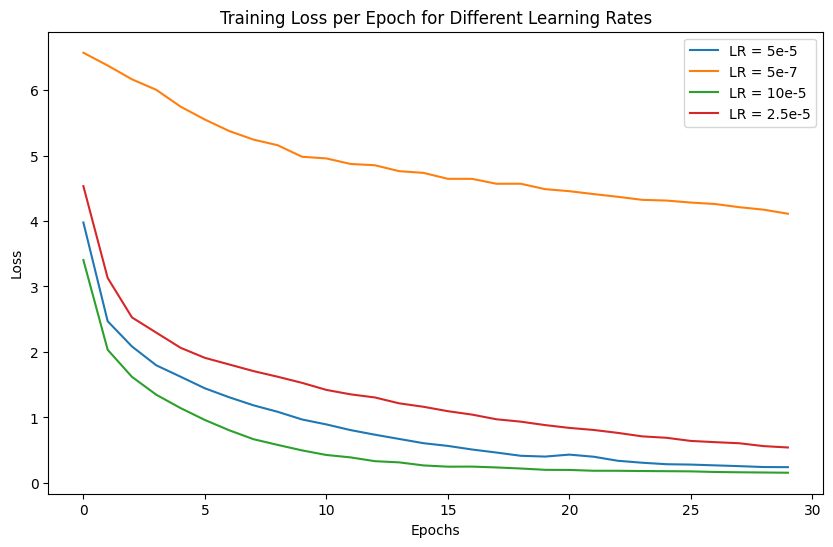

In [25]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(losses, label='LR = 5e-5')
plt.plot(losses2, label='LR = 5e-7')
plt.plot(losses4, label='LR = 10e-5')
plt.plot(losses5, label='LR = 2.5e-5')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch for Different Learning Rates')
plt.legend()
plt.show()

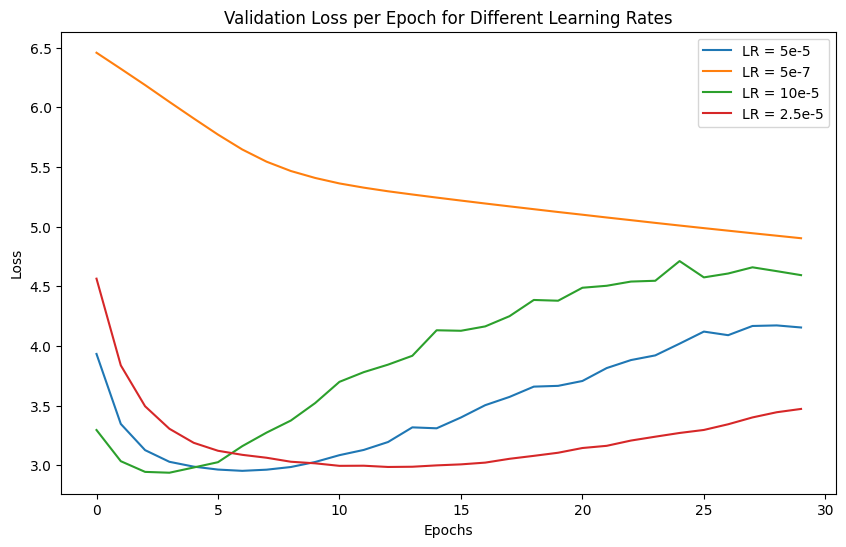

In [41]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(vallosses, label='LR = 5e-5')
plt.plot(vallosses2, label='LR = 5e-7')
plt.plot(vallosses4, label='LR = 10e-5')
plt.plot(vallosses5, label='LR = 2.5e-5')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch for Different Learning Rates')
plt.legend()
plt.show()

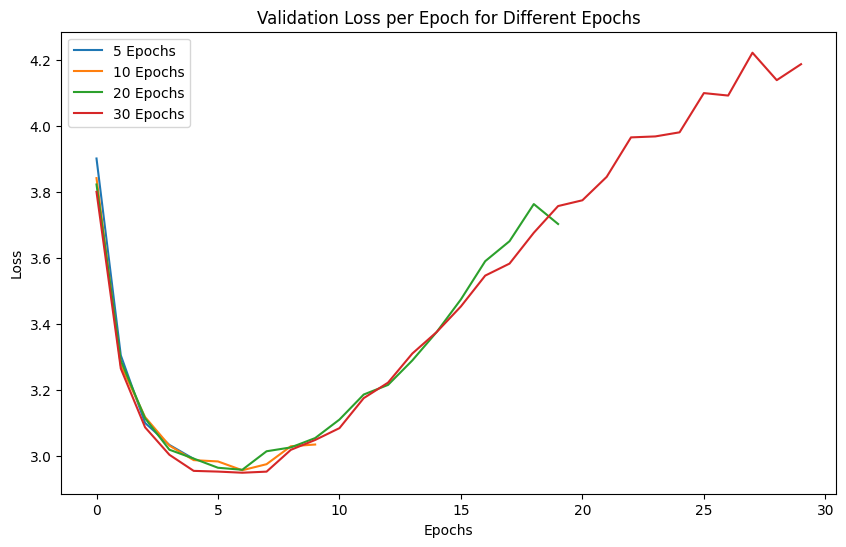

In [48]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(vallosses, label='5 Epochs')
plt.plot(vallosses2, label='10 Epochs')
plt.plot(vallosses4, label='20 Epochs')
plt.plot(vallosses5, label='30 Epochs')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch for Different Epochs')
plt.legend()
plt.show()

In [7]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [10]:
#calculate meteor and total length of generated responses (to find average just divide by number of generated responses)
tokenized_generated_responses = [response.split() for response in generated_responses]
tokenized_train_responses = [response.split() for response in test_response]
meteor_scores = [meteor_score([ref], gen) for ref, gen in zip(tokenized_train_responses, tokenized_generated_responses)]
average_meteor_score = sum(meteor_scores) / len(meteor_scores)
print("Average METEOR Score:", average_meteor_score)
total_length = sum(len(response.split()) for response in generated_responses)
print("Total Length of Generated Responses:", total_length)

Average METEOR Score: 0.07856915984730871
Total Length of Generated Responses: 5665


In [40]:
#this code block does the score calculations for the finetuned DialoGPT model trained on the Customer-Support dataset using the test set from test.csv
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from tqdm import tqdm
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
tokenizer.pad_token = '[PAD]'
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small").to(device)
file_path = '/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/Customer-Support.csv'
full_data = pd.read_csv(file_path)
print(full_data)
full_data = full_data[['query', 'response']]
test_data = pd.read_csv('/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/test.csv')
train_size = int(len(full_data))
train_data= fine_tune_data
train_response = []
train_query = []
train_data = pd.DataFrame(train_data)
for index, row in train_data.iterrows():
    value1 = row['query']
    value2 = row['response']
    train_query.append(value1)
    train_response.append(value2)
test_response = []
test_query = []
test_data = pd.DataFrame(test_data)
for index, row in test_data.iterrows():
    value1 = row['query']
    value2 = row['response']
    test_query.append(value1)
    test_response.append(value2)

tokenized_train_data = tokenizer(train_query, train_response, padding=True, truncation=True, return_tensors='pt')
class CustomDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)
train_dataset = CustomDataset(tokenized_train_data)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} finished, Average Loss: {average_loss}")
save_directory = '/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/finetuned_notaug'
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

fine_tuned_model_path = '/content/drive/My Drive/cs182 final proj/CodeForCollab/data182/finetuned_notaug'
fine_tuned_model = AutoModelForCausalLM.from_pretrained(fine_tuned_model_path).to(device)
model = fine_tuned_model
generated_responses = []

#generate responses from the model based on the test queries and find scores
for i in range(len(test_query)):
  bot_input_ids = tokenizer.encode(test_query[i] + tokenizer.eos_token, return_tensors='pt').to(device)
  chat_history_ids = model.generate(bot_input_ids, max_length=200, pad_token_id=tokenizer.eos_token_id).to("cpu")
  generated_responses.append(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True))

bleu_scores = [sentence_bleu([actual_response], generated_response) for actual_response, generated_response in zip(test_response, generated_responses)]
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU Score:", average_bleu_score)
tokenized_generated_responses = [response.split() for response in generated_responses]
tokenized_train_responses = [response.split() for response in train_response]

meteor_scores = [meteor_score([ref], gen) for ref, gen in zip(tokenized_train_responses, tokenized_generated_responses)]
average_meteor_score = sum(meteor_scores) / len(meteor_scores)
print("Average METEOR Score:", average_meteor_score)

total_length = sum(len(response.split()) for response in generated_responses)
print("Total Length of Generated Responses:", total_length)

print(len(generated_responses))

                                               query  \
0                       My order hasn't arrived yet.   
1                      I received a damaged product.   
2                          I need to return an item.   
3              I want to change my shipping address.   
4                   I have a question about my bill.   
..                                               ...   
68  How do I schedule a consultation or appointment?   
69                   Can I get a copy of my receipt?   
70    Can I use a competitor's coupon at your store?   
71                  Do you have a recycling program?   
72       How do I report a lost or stolen gift card?   

                                             response  
0   We apologize for the inconvenience. Can you pl...  
1   We apologize for the inconvenience. Can you pl...  
2   Certainly. Please provide your order number an...  
3   No problem. Can you please provide your order ...  
4   We'd be happy to help. Can you please provi

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0 finished, Average Loss: 4.008609569072723
Epoch 1 finished, Average Loss: 2.5458949208259583


KeyboardInterrupt: ignored